In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
from scipy.stats import mannwhitneyu

In [117]:
import warnings
warnings.filterwarnings('ignore')

Итак, нас инересует то, влияет ли модель на следующие показатели:
- объём продаж в натуральном выражении
- количество потраченных баллов
- количество транзакций

У нас уже есть модель на основе метода А. При этом в результате прототипирования метод B показал лучшие по сравнению с А 
офлайн-метрики. Необходимо проверить, влияет ли решение B на те показатели, которые обозначили выше. Нам важно не ошибиться
и не сказать в итоге, что различия значимы.

У нас 2 гипотезы:
- "нулевая" (H0) - наблюдаемые различия незначимы
- "альтернативная" (H1) - различия значимы

Тест Колмогорова-Смирнова

In [66]:
def test(data, x):
    ks, p = kstest(data[x], 'norm')
    return p

Множественное сравнение.

In [118]:
def multiple_comparisons(data, features, test):
    p_values = []
    group_a = data[data['ab_group'] == 'A']
    group_b = data[data['ab_group'] == 'B']
    
    for i in data[features]:
        _, p = test(group_a[i], group_b[i])
        p_values.append(p)
    
    return p_values

График p-значений.

In [102]:
def plot_p_values(p_values, threshold, bins):
    sns.set(font_scale=1.2)
    plt.figure(figsize=(7, 3))
    sns.distplot([p_values], kde=False, bins=bins)
    plt.axvline(x=threshold, color='r', linestyle='--')
    
    plt.xlim([0, 1])
    plt.xlabel('$\it{p}$ value')
    plt.ylabel('Count')
    plt.tight_layout()

Поправка Холма-Бонферонни.

In [120]:
def holm_bonferonni_correction(data, p_values, threshold):
    counter = 0
    step = 0
    
    for p in p_values:
        value = p/((data.shape[1]-1) - step)
        step += 1

        if not value < threshold:
            break
        else:
            counter += 1
    
    return (counter/len(p_values))*100

Приступим к работе.

In [2]:
path = 'E:/retailhero-uplift/data'

In [37]:
ab = pd.read_csv(path + '/ab_test.csv', index_col='client_id')
ab.head()

,total_trans_count,product_quantity_sum_all,regular_points_spent_sum_all,ab_group
client_id,,,,
000012768d,4,3,0.0,B
000036f903,32,5,0.0,B
00010925a5,18,2,-17.0,A
0001f552b0,15,4,0.0,B
00020e7b18,18,4,-592.0,A


In [38]:
ab[ab['ab_group'] == 'A'].describe()

,total_trans_count,product_quantity_sum_all,regular_points_spent_sum_all
count,99968.000000,99968.000000,99968.000000
mean,20.165943,2.920294,-73.322553
std,17.829443,1.968733,128.257498
min,1.000000,1.000000,-4173.000000
25%,8.000000,2.000000,-98.000000
50%,15.000000,2.000000,-27.000000
75%,27.000000,4.000000,0.000000
max,320.000000,34.000000,0.000000


In [39]:
ab[ab['ab_group'] == 'B'].describe()

,total_trans_count,product_quantity_sum_all,regular_points_spent_sum_all
count,100071.000000,100071.000000,100071.000000
mean,20.075746,2.921086,-73.471545
std,17.634355,2.041020,136.639585
min,1.000000,1.000000,-10131.000000
25%,8.000000,2.000000,-98.000000
50%,15.000000,2.000000,-27.000000
75%,27.000000,4.000000,0.000000
max,307.000000,95.000000,0.000000


По описательным статистикам не видно никакой разницы. Посмотрим на распределения.

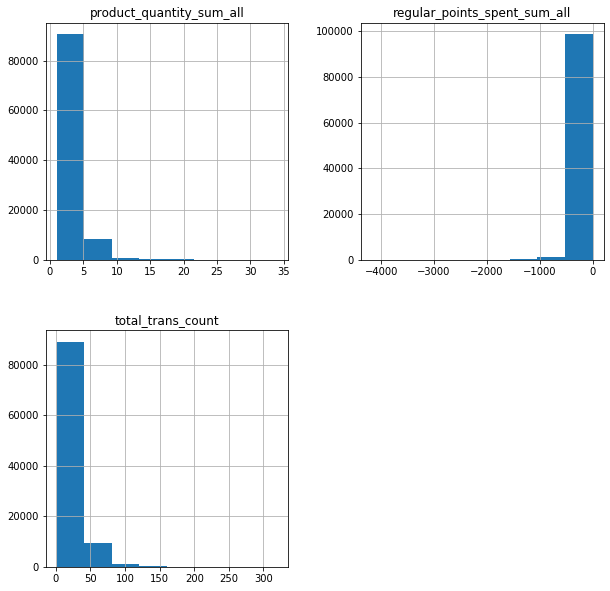

In [48]:
ab[ab['ab_group'] == 'A'].hist(figsize=(10,10), bins=8, grid=True);

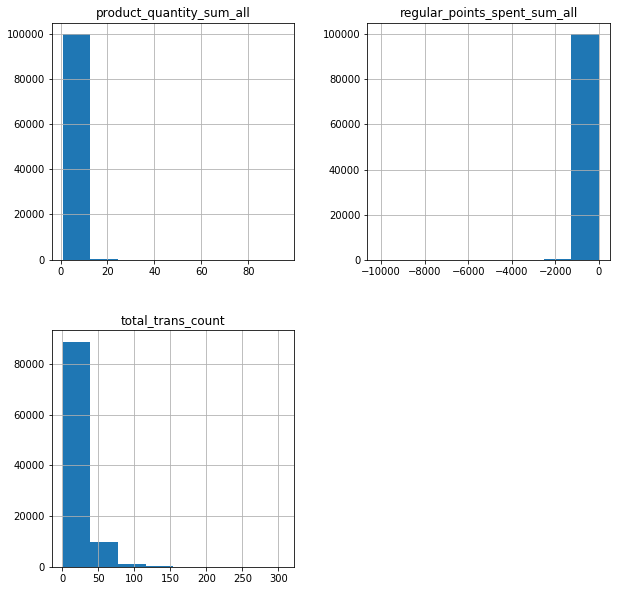

In [51]:
ab[ab['ab_group'] == 'B'].hist(figsize=(10,10), bins=8, grid=True);

Нормальным распределение не выглядит. Проверим при помощи критерия Колмогорова-Смирнова.

In [68]:
features = ['total_trans_count', 'product_quantity_sum_all', 'regular_points_spent_sum_all']

In [71]:
list(map(lambda x: test(ab[ab['ab_group'] == 'A'], x), features))

[0.0, 0.0, 0.0]

In [72]:
list(map(lambda x: test(ab[ab['ab_group'] == 'B'], x), features))

[0.0, 0.0, 0.0]

Для всех признаков в обоих группах распределение не является нормальным. Проверим различия критерием Манна-Уитни.

У нас есть контрольная группа и эксперементальная. При этом, нам важно не допустить ошибку второго рода, т.е. получить неверный
ответ о том, что различия между группами значимы и запустить в прод не ту модель. 
Проблема заключается в том, что подведение итогов с уровнем значимости 0.05  может привести к кратному росту доли ошибок первого/второго рода. Это может произойти, потому что при каждом применении статистического критерия вероятность ошибки рода будет 5%. Будем использовать поправку Холма-Бонферонни.

P-value первой гипотезы сравнивается с уровнем статистический значимости $\alpha/ngroups$. Если гипотеза принимается, 
то переходим ко второй и сравниваем её p-value с уровнем статистической значимости $\alpha/(ngroups − 1)$, и так далее. 
Как только какая-то гипотеза отвергается, процесс останавливается и все оставшиеся гипотезы так же отвергаются. 
Самое жёсткое требование (и такое же, как в поправке Бонферрони) накладывается на гипотезу с наименьшим p-value, 
а большая мощность достигается за счёт менее жёстких условий для последующих гипотез. 

In [100]:
p_values = multiple_comparisons(ab, features, mannwhitneyu)

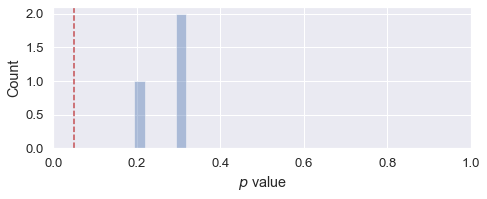

In [103]:
plot_p_values(p_values, threshold=0.05, bins=5)

In [115]:
print(f'Количество статистически значимых результатов составляет {holm_bonferonni_correction(data=ab, p_values=p_values, threshold=0.05)} процентов')

Количество статистически значимых результатов составляет 100.0 процентов


Если бы нам было необходимо учитывать потери альтернативных доходов, надо было бы использовать обычную поправку Бонферонни.

Итак, мы не видим статистически значимых результатов в искомых показателях между группами А и B.
Поэтому, на уровне значимости 0.05, мы отвергаем гипотезу о том, что новая модель повлияла на показатели и её не имеет смысла
выпускать в прод.